# SNR estimation

## 1. Main construction

### Setup

Let $x(t)$ be source neuronal signal for $t \in [0, T]$

Let $k(t)$ be the response function of calcium indicator. Then the source calcium signal

$$y(t) = \int_{0}^{\infty} k(\tau) x(t - \tau) d\tau$$

The signal is integrated over fixed time intervals $\Delta t$ upon collection. It also experiences i.i.d white noise $\nu_i \sim \mathcal{N}(0, \sigma^2)$ with unknown variance.

$$y_i = \int_{i\Delta t}^{{(i+1)\Delta t}} y(t) + \nu_i = y^{src}_i + \nu_i$$

### SNR detection via autocorrelation

If kernel timescale $t_k = STD(k)$ is sufficiently slow compared to the sampling timescale $\Delta t$, we can assume that the autocorrelation of the source signal will be much more smooth than that of white noise.

Autocorrelation of steps $i$ and $j$ is defined as

$$AC_{ij} = \frac{\langle (y_i - \mu_i)(y_j - \mu_j) \rangle}{\sigma_i \sigma_j}$$

where

$$\mu_i = \langle y_i \rangle = \langle y^{src}_i + \nu_i \rangle = \mu_{src}$$

and

$$\sigma_i^2 = \langle (y_i - \mu_i)^2 \rangle = \langle (y^{src}_i - \mu_i)^2 + 2(y_i - \mu_i)\nu_i + \nu_i^2 \rangle = \sigma_{src}^2 + \sigma_{\nu}^2$$

where the interference terms are zero because white noise is assumed to be uncorrelated with the signal. Thus we can rewrite the autocorrelation as

$$
AC_{ij} = \frac{\langle 
  (y^{src}_i - \mu_i)(y^{src}_j - \mu_j)
  + (y^{src}_i - \mu_i)\nu_j
  + \nu_i(y^{src}_j - \mu_j)
  + \nu_i \nu_j
\rangle}{\sigma_{src}^2 + \sigma_{\nu}^2} = 
\frac{\sigma_{src}^2 \rho^{src}_{ij}}{\sigma_{src}^2 + \sigma_{\nu}^2} = 
\frac{\rho^{src}_{ij}}{1 + SNR}
$$
where the last 3 terms are zero because white noise is uncorrelated with the signal and also is uncorrelated with itself. Thus, autocorrelation of the observed signal is proportional to autocorrelation of the raw signal and inverse-proportional to $(1 + SNR)$.

Finally, as a first order approximation we will assume time-invariance of the source signal, meaning that, in a random trial, mean and variance of the signal is the same for all timesteps. Hence,

$$\mu^{src}_i = \mu^{src} \forall i \; ;\;\;  \sigma^{src}_i = \sigma^{src} \forall i$$

and

$$AC_{ij} = AC_{k, k+(j-i)} = AC_k \;\; \forall i,j,k$$

### Estimation of $AC_k$

In order to compute the $k$-step autocorrelation, we replace all expectation values with averages over timesteps and trials simultaneously. Note that there is no need for bias correction, because the bias multiplier is the same for the numerator and the denominator.

### Estimation of SNR

SNR can be estimated from a single step autocorrelation
1. Make a guess for $k(t)$
2. Simulate expected value for $AC_k$
3. Calculate expected value for SNR


## 2. Inequality constraints

Above is an approximate relationship of sample and source autocorrelation and SNR. In order for this estimator to be practically useful, additional work is required:
* Construct lower bound for $\rho_k$ given kernel STD. Hence construct lower bound on SNR
* Estimate effects of finite sample size on $AC_{ij}$ expansion. Derive first order correcton $O(1/n)$
* Estimate effects of changing trial

## 3. Extension

* Can values of $AC_k$ for multiple $k$ be combined to better estimate SNR?
* Can one estimate kernel timescale given its shape?

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def expDistr(t, tau):
    return np.exp(-t/tau) / tau

def autocorr(x, norm=False):
    ac = np.correlate(x, x, mode='full')[len(x)-1:]
    if norm:
        return ac / ac[0]
    else:
        return ac

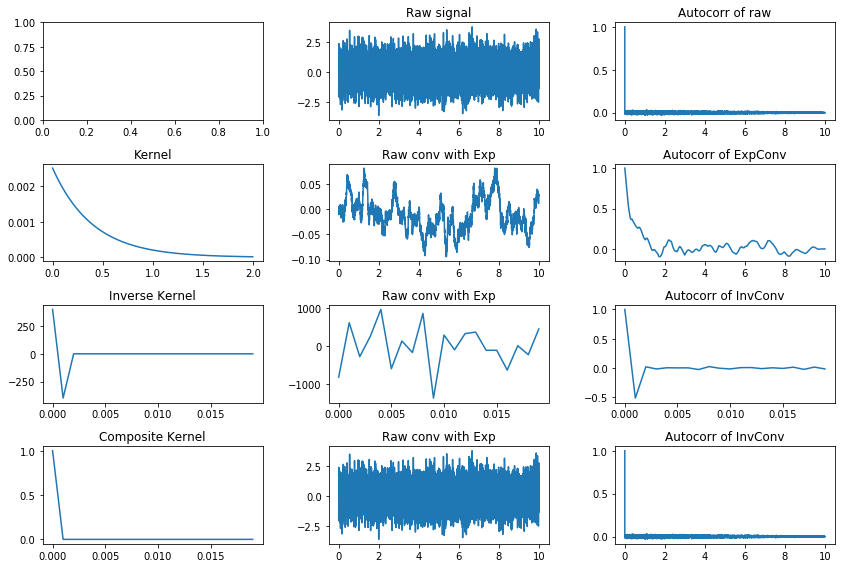

In [51]:
T = 10      # s, simulation time
dt = 0.001  # s
tau = 0.4   # s, exp kernel timescale
nData = int(T / dt)
nKer = int(5 * tau / dt)

tRaw = np.arange(nData) * dt
xRaw = np.random.normal(0, 1, nData)
tKer = np.arange(nKer) * dt
k = expDistr(tRaw, tau)[:nKer]
k /= np.sum(k)

acRaw = autocorr(xRaw, norm=True)
yDirect = np.convolve(k, xRaw, mode='full')[:nData]
acDirect = autocorr(yDirect, norm=True)

kInv = np.fft.ifft(1/np.fft.fft(k))
yInv = np.convolve(kInv, xRaw, mode='full')[:nData]
acInv = autocorr(yInv, norm=True)

kComposite = np.convolve(k, kInv, mode='full')[:nKer]
yIndirect = np.convolve(k, yInv, mode='full')[:nData]
acIndirect = autocorr(yIndirect, norm=True)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 8), tight_layout=True)

ax[0,1].set_title('Raw signal')
ax[0,1].plot(tRaw, xRaw)

ax[1,0].set_title('Kernel')
ax[1,0].plot(tKer, k)

ax[0,2].set_title('Autocorr of raw')
ax[0,2].plot(tRaw, acRaw)

ax[1,1].set_title('Exp conv to Raw')
ax[1,1].plot(tRaw, yDirect)

ax[1,2].set_title('Autocorr of ExpConv')
ax[1,2].plot(tRaw, acDirect)

ax[2,0].set_title('Inverse Kernel')
ax[2,0].plot(tKer[:20], kInv[:20])

ax[2,1].set_title('Raw conv with Inverse')
ax[2,1].plot(tRaw[:20], yInv[:20])

ax[2,2].set_title('Autocorr of InvConv')
ax[2,2].plot(tRaw[:20], acInv[:20])

ax[3,0].set_title('Composite Kernel')
ax[3,0].plot(tKer[:20], kComposite[:20])

ax[3,1].set_title('Inverse conv with Exp')
ax[3,1].plot(tRaw, yIndirect)

ax[3,2].set_title('Autocorr of InvConv')
ax[3,2].plot(tRaw, acIndirect)




plt.show()

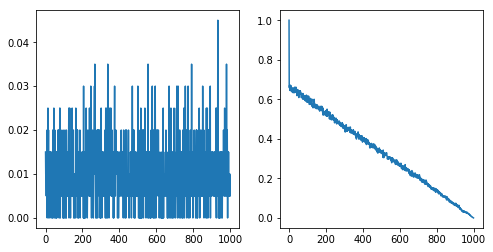

In [58]:
spikes = np.mean(np.random.uniform(0, 1, (1000, 200)) < 0.01, axis=1)
acSpikes = autocorr(spikes, norm=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(spikes)
ax[1].plot(acSpikes)
plt.show()